# **Face Expression Classification for Suicide Crisis Detection**

## **Data Understanding**

### 📊 Ringkasan Dataset

Dataset ini berisi gambar ekspresi wajah yang digunakan untuk mengidentifikasi tanda-tanda krisis bunuh diri melalui analisis visual. Dataset terdiri dari dua kategori utama yang mengklasifikasikan kondisi mental seseorang berdasarkan ekspresi wajah mereka.

### 📁 Struktur Dataset

```
data/1. DATA EKSPRESI WAJAH KRISI BUNUH DIRI/
├── 1. KRISIS/          # Gambar ekspresi wajah yang menunjukkan tanda krisis
└── 2. TIDAK KRISIS/    # Gambar ekspresi wajah yang tidak menunjukkan tanda krisis
```

### 📈 Distribusi Data

| Kategori         | Jumlah Gambar | Persentase |
| ---------------- | ------------- | ---------- |
| **Krisis**       | 464           | 22.1%      |
| **Tidak Krisis** | 1,636         | 77.9%      |
| **Total**        | 2,100         | 100%       |

#### Visualisasi Distribusi Kelas

```
Tidak Krisis: ████████████████████████████████████████████████████████████████████████████████ 77.9%
Krisis:       ████████████████████████                                                         22.1%
```

### 🔧 Karakteristik Teknis

#### Spesifikasi Gambar

- **Resolusi**: 48x48 piksel
- **Format**: JPEG (.jpg)
- **Mode Warna**: Grayscale/RGB (perlu konfirmasi lebih lanjut)
- **Ukuran File**: 1.1 - 1.7 KB per gambar (rata-rata ~1.4 KB)

#### Penamaan File

- **Format Penamaan**: Numerik (contoh: 10164.jpg, 10165.jpg)
- **Pola**: Tidak ada pola khusus yang teridentifikasi dalam penamaan
- **Range**: Angka bervariasi dari ratusan hingga puluhan ribu

### 📊 Analisis Distribusi Kelas

#### Ketidakseimbangan Dataset (Class Imbalance)

Dataset menunjukkan **ketidakseimbangan kelas yang signifikan**:

- Kelas mayoritas: "Tidak Krisis" (77.9%)
- Kelas minoritas: "Krisis" (22.1%)
- **Rasio**: ~3.5:1 (Tidak Krisis : Krisis)

#### Implikasi Ketidakseimbangan

1. **Model Bias**: Model cenderung memprediksi kelas mayoritas
2. **Evaluasi Metrik**: Akurasi saja tidak cukup, perlu precision, recall, F1-score
3. **Strategi Penanganan**: Diperlukan teknik seperti:
   - Oversampling (SMOTE)
   - Undersampling
   - Class weighting
   - Ensemble methods

### 🎯 Karakteristik Domain

#### Konteks Aplikasi

- **Domain**: Kesehatan Mental / Psikologi
- **Tujuan**: Deteksi dini krisis bunuh diri melalui ekspresi wajah
- **Sensitivitas**: Dataset sangat sensitif dan memerlukan penanganan etis

#### Tantangan Khusus

1. **Subjektivitas**: Interpretasi ekspresi wajah dapat bervariasi
2. **Privasi**: Data sangat sensitif dan personal
3. **Etika**: Penggunaan harus mempertimbangkan aspek etis dan consent
4. **Akurasi Tinggi**: False negative dapat berakibat fatal


## **Data Preparation**

### Download Data dari Google Drive

In [12]:
import gdown
import zipfile
import os

# ID file dari link Google Drive
file_id = "14f2FMGfZ88qznJi46wPgnEnHAGphhIuo"
url = f"https://drive.google.com/uc?id={file_id}"

output_zip = "data/face.zip"
extract_dir = "data"

# Pastikan folder data ada
os.makedirs("data", exist_ok=True)

# Selalu cek apakah sudah ada hasil ekstrak
if not os.path.exists(extract_dir+"/1. DATA EKSPRESI WAJAH KRISI BUNUH DIRI"):
    print("[INFO] Mengunduh file zip...")
    gdown.download(url, output_zip, quiet=False)

    print("[INFO] Mengekstrak file...")
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    os.remove(output_zip)
    print("[INFO] File zip dihapus.")
else:
    print("[SKIP] Folder sudah ada, tidak perlu download ulang.")

print("[SELESAI] Dataset tersedia di folder:", extract_dir)

[SKIP] Folder sudah ada, tidak perlu download ulang.
[SELESAI] Dataset tersedia di folder: data


### Mengatur Konfigurasi

In [1]:
import os
import random
from pathlib import Path
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset, WeightedRandomSampler
from torchvision import transforms, models, datasets

from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
)

import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch_directml
device = torch_directml.device()
print("[INFO] Using device:", device)

[INFO] Using device: privateuseone:0


In [ ]:
SEED = 2025
BATCH_SIZE = 32
IMG_SIZE = 48
NUM_EPOCHS = 30
LEARNING_RATE = 1e-3
DATA_ROOT = "data/1. DATA EKSPRESI WAJAH KRISI BUNUH DIRI"
MODEL_PATH = "models/face-expression-directml.pt"
PATIENCE = 5
NUM_WORKERS = 0

# reproducible
def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything()

### Data Transformation & Augmentation

In [4]:
class To3Channels:
    def __call__(self, x):
        return x.repeat(3, 1, 1) if x.shape[0] == 1 else x

In [5]:
def build_transforms(img_size=IMG_SIZE):
    train_tf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        To3Channels(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    val_tf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        To3Channels(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    return train_tf, val_tf

train_tf, val_tf = build_transforms()

### Data Loading

In [6]:
# Load dataset using ImageFolder - expects two subfolders (e.g. "1. KRISIS", "2. TIDAK KRISIS")
if not os.path.exists(DATA_ROOT):
    raise FileNotFoundError(f"Data root not found: {DATA_ROOT}")

full_dataset = datasets.ImageFolder(root=DATA_ROOT, transform=train_tf)
class_names = full_dataset.classes
num_classes = len(class_names)
print("[INFO] Classes:", class_names, "Num classes:", num_classes)
print("[INFO] Total images:", len(full_dataset))

[INFO] Classes: ['1. KRISIS', '2. TIDAK KRISIS'] Num classes: 2
[INFO] Total images: 2100


#### Data Splitting

In [ ]:
# -------------------------
# Split dataset 80:10:10
# -------------------------
def split_dataset(dataset, seed=SEED):
    n = len(dataset)
    n_train = int(0.8 * n)
    n_val = int(0.1 * n)
    n_test = n - n_train - n_val
    lengths = [n_train, n_val, n_test]
    train_ds, val_ds, test_ds = random_split(
        dataset, lengths, generator=torch.Generator().manual_seed(seed)
    )
    # set transform untuk masing-masing subset
    train_ds.dataset.transform = train_tf
    val_ds.dataset.transform = val_tf
    test_ds.dataset.transform = val_tf
    return train_ds, val_ds, test_ds

In [8]:
# panggil split
train_ds, val_ds, test_ds = split_dataset(full_dataset)
print("[INFO] Split sizes -> train:", len(train_ds), "val:", len(val_ds), "test:", len(test_ds))

[INFO] Split sizes -> train: 1680 val: 210 test: 210


#### Handling Class Imbalance

In [9]:
# Ambil label sesuai subset training
train_targets = [full_dataset.samples[i][1] for i in train_ds.indices]
counter = Counter(train_targets)
print("[INFO] Train class distribution:", counter)

[INFO] Train class distribution: Counter({1: 1304, 0: 376})


In [10]:
# Calculate class distribution & class weights (for loss)
targets = [y for _, y in full_dataset.samples]
counter = Counter(targets)
print("[INFO] Class counts:", counter)

[INFO] Class counts: Counter({1: 1636, 0: 464})


In [11]:
# Hitung class weights untuk CrossEntropyLoss
total = sum(counter.values())
class_weights = []
for i in range(len(counter)):
    class_weights.append(total / (len(counter) * counter[i]))
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("[INFO] Class weights:", class_weights)

[INFO] Class weights: tensor([2.2629, 0.6418], device='privateuseone:0')


In [12]:
# Buat sample_weights sesuai subset training
weights = 1. / torch.tensor([counter[i] for i in range(len(counter))], dtype=torch.float)
sample_weights = [weights[label] for label in train_targets]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [13]:
# DataLoader dengan sampler agar batch lebih seimbang
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("[INFO] DataLoaders updated with WeightedRandomSampler")

[INFO] DataLoaders updated with WeightedRandomSampler


## **Modelling**

In [14]:
# Build a compact but effective CNN using a pretrained backbone (MobileNetV2) and a small classification head.
def get_model(num_classes, variant="large"):
    if variant == "large":
        model = models.mobilenet_v3_large(pretrained=True)
        in_feats = model.classifier[0].in_features   # 960
    else:
        model = models.mobilenet_v3_small(pretrained=True)
        in_feats = model.classifier[0].in_features   # 576

    model.classifier = nn.Sequential(
        nn.Linear(in_feats, 128),
        nn.Hardswish(),
        nn.Dropout(p=0.3),
        nn.Linear(128, num_classes)
    )
    return model

model = get_model(num_classes, variant="large").to(device)
print("[INFO] Model created.")

[INFO] Model created.


In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(weight=class_weights)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.1618, verbose=True)

In [16]:
# Simple EarlyStopping + ModelCheckpoint
class EarlyStopping:
    def __init__(self, patience=PATIENCE, verbose=True, path=MODEL_PATH):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.verbose = verbose
        self.path = path

    def step(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - 1e-4:
            self.best_loss = val_loss
            self.counter = 0
            # save model
            torch.save(model.state_dict(), self.path)
            if self.verbose:
                print(f"[CHECKPOINT] Saved new best model (val_loss={val_loss:.4f}) -> {self.path}")
        else:
            self.counter += 1
            if self.verbose:
                print(f"[EARLYSTOP] No improvement ({self.counter}/{self.patience})")
            if self.counter >= self.patience:
                self.early_stop = True

In [17]:
# -------------------------
# Training / Validation loops
# -------------------------
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

@torch.no_grad()
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * imgs.size(0)
        probs = F.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    avg_loss = running_loss / total
    acc = correct / total
    all_probs = np.vstack(all_probs)
    all_labels = np.concatenate(all_labels)
    return avg_loss, acc, all_probs, all_labels

In [18]:
# -------------------------
# Training Loop
# -------------------------
def fit(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs=NUM_EPOCHS):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    stopper = EarlyStopping(patience=PATIENCE, verbose=True, path=MODEL_PATH)
    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc, val_probs, val_labels = validate(model, val_loader, criterion)
        scheduler.step(val_loss)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        print(f"train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f}")
        print(f"val_loss:   {val_loss:.4f} | val_acc:   {val_acc:.4f}")
        # early stopping + checkpoint
        stopper.step(val_loss, model)
        if stopper.early_stop:
            print("[INFO] Early stopping triggered.")
            break
    # load best model
    if os.path.exists(MODEL_PATH):
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    return model, history

In [19]:
trained_model, history = fit(model, train_loader, val_loader,
                                 optimizer, criterion, scheduler, epochs=NUM_EPOCHS)


Epoch 1/30
train_loss: 0.4451 | train_acc: 0.6250
val_loss:   0.6228 | val_acc:   0.5857
[CHECKPOINT] Saved new best model (val_loss=0.6228) -> models/best_model.pt

Epoch 2/30
train_loss: 0.2842 | train_acc: 0.8077
val_loss:   0.7128 | val_acc:   0.6429
[EARLYSTOP] No improvement (1/5)

Epoch 3/30
train_loss: 0.2410 | train_acc: 0.8560
val_loss:   0.9880 | val_acc:   0.5952
[EARLYSTOP] No improvement (2/5)

Epoch 4/30
train_loss: 0.1527 | train_acc: 0.9173
val_loss:   0.9976 | val_acc:   0.6905
[EARLYSTOP] No improvement (3/5)

Epoch 5/30
train_loss: 0.0771 | train_acc: 0.9536
val_loss:   1.0882 | val_acc:   0.7762
[EARLYSTOP] No improvement (4/5)

Epoch 6/30
train_loss: 0.0671 | train_acc: 0.9655
val_loss:   1.0665 | val_acc:   0.7952
[EARLYSTOP] No improvement (5/5)
[INFO] Early stopping triggered.


## **Evaluation**

### Hasil Training

In [20]:
   # Evaluation on test set
# -------------------------
@torch.no_grad()
def predict_on_loader(model, loader):
    model.eval()
    ys = []
    probs = []
    for imgs, labels in loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        p = F.softmax(outputs, dim=1).cpu().numpy()
        probs.append(p)
        ys.append(labels.numpy())
    probs = np.vstack(probs)
    ys = np.concatenate(ys)
    preds = probs.argmax(axis=1)
    return ys, preds, probs

y_true, y_pred, y_prob = predict_on_loader(trained_model, test_loader)

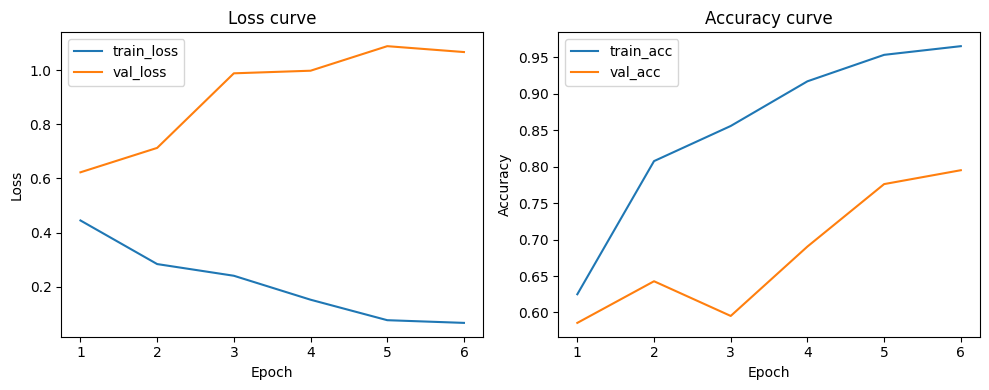

In [21]:
 # -------------------------
# Plots: training curves
# -------------------------
def plot_training(history, out="training_plot.png"):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss curve")
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy curve")
    plt.tight_layout()

plot_training(history)

### ROC-AUC Score

[INFO] ROC AUC (binary): 0.6686 saved to roc_auc.png


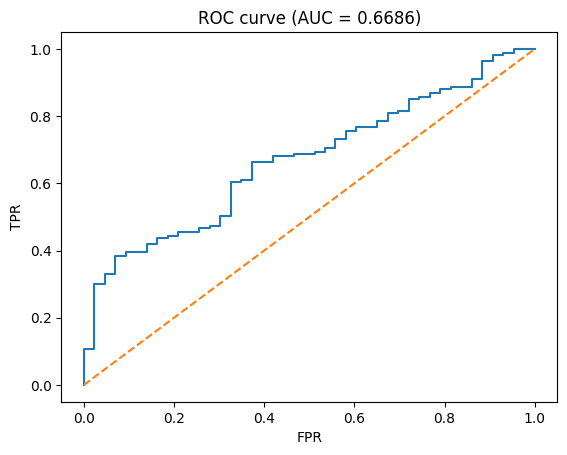

In [22]:
 # -------------------------
# ROC AUC (binary or multiclass handling)
# -------------------------
def compute_roc_auc(y_true, y_prob):
    if num_classes == 2:
        # take prob of positive class (assume class 1 is positive)
        pos_prob = y_prob[:, 1]
        auc = roc_auc_score(y_true, pos_prob)
        fpr, tpr, _ = roc_curve(y_true, pos_prob)
        plt.figure()
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1], linestyle='--')
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title(f"ROC curve (AUC = {auc:.4f})")
        print(f"[INFO] ROC AUC (binary): {auc:.4f} saved to roc_auc.png")
        return auc
    else:
        # multiclass: macro ROC AUC
        try:
            auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
            print(f"[INFO] ROC AUC (multiclass, macro): {auc:.4f}")
            return auc
        except Exception as e:
            print("[WARN] ROC AUC could not be computed:", e)
            return None
        
auc = compute_roc_auc(y_true, y_prob)

### Confusion Matrix

[DONE] Training and evaluation complete. Best model saved to: models/best_model.pt


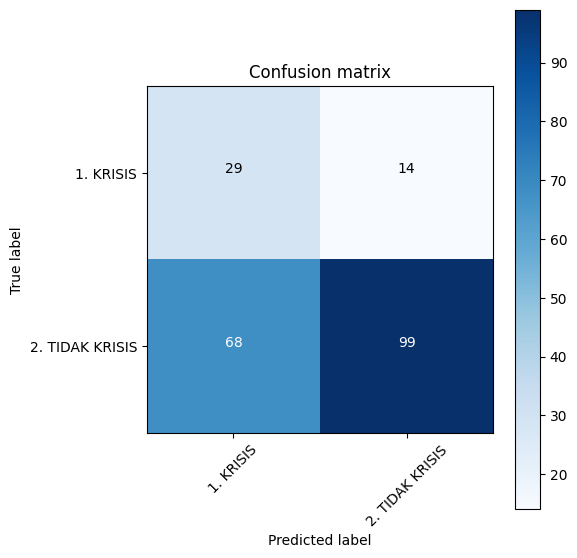

In [23]:
def plot_cm(cm, classes):
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(y_true, y_pred)
plot_cm(cm, class_names)
print("[DONE] Training and evaluation complete. Best model saved to:", MODEL_PATH)

### Classification Report

In [24]:
print("[INFO] Classification report:\n", classification_report(y_true, y_pred, target_names=class_names, digits=4))

[INFO] Classification report:
                  precision    recall  f1-score   support

      1. KRISIS     0.2990    0.6744    0.4143        43
2. TIDAK KRISIS     0.8761    0.5928    0.7071       167

       accuracy                         0.6095       210
      macro avg     0.5875    0.6336    0.5607       210
   weighted avg     0.7579    0.6095    0.6472       210



## **Convert Model**

In [1]:
import torch
import torch_directml
import torch.nn as nn
import torchvision.models as models

def get_model(num_classes, variant="large"):
    if variant == "large":
        model = models.mobilenet_v3_large(weights="IMAGENET1K_V1")
        in_feats = model.classifier[0].in_features
    else:
        model = models.mobilenet_v3_small(weights="IMAGENET1K_V1")
        in_feats = model.classifier[0].in_features

    model.classifier = nn.Sequential(
        nn.Linear(in_feats, 128),
        nn.Hardswish(),
        nn.Dropout(p=0.3),
        nn.Linear(128, num_classes)
    )
    return model

device = torch.device("cpu")
model = get_model(num_classes=2, variant="large").to(device)

# 🔥 load lama → pakai weights_only=False
checkpoint = torch.load("models/face-expression-directml.pt", map_location=device, weights_only=False)

# kalau ternyata checkpoint sudah OrderedDict
if isinstance(checkpoint, dict):
    try:
        model.load_state_dict(checkpoint)
    except RuntimeError:
        # mungkin tersimpan dict dengan key lain, misalnya {"model": state_dict}
        model.load_state_dict(checkpoint["model"])
else:
    # kalau ternyata full nn.Module
    model.load_state_dict(checkpoint.state_dict())

# ✅ simpan ulang jadi state_dict portable
torch.save(model.state_dict(), "models/face-expression.pt")
print("[INFO] Konversi selesai → gunakan 'models/face-expression.pt'")

[INFO] Konversi selesai → gunakan 'models/face-expression.pt'


## **Load Model**

### Using Direct ML

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models

# Sama seperti definisi training
def get_model(num_classes, variant="large"):
    if variant == "large":
        model = models.mobilenet_v3_large(pretrained=True)
        in_feats = model.classifier[0].in_features   # 960
    else:
        model = models.mobilenet_v3_small(pretrained=True)
        in_feats = model.classifier[0].in_features   # 576

    model.classifier = nn.Sequential(
        nn.Linear(in_feats, 128),
        nn.Hardswish(),
        nn.Dropout(p=0.3),
        nn.Linear(128, num_classes)
    )
    return model

# ======================
# Load kembali model
# ======================

import torch_directml
device = torch_directml.device()

num_classes = 2
model = get_model(num_classes=num_classes, variant="large").to(device)

# Load state_dict
model.load_state_dict(torch.load("models/face-expression.pt", map_location=device))

model.eval()
print("[INFO] Model loaded and ready for inference.")

c:\Users\harry\anaconda3\envs\torch-directml\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\harry\anaconda3\envs\torch-directml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO] Model loaded and ready for inference.


### Using CUDA or CPU

In [2]:
import torch
import torch.nn as nn
import torch_directml
import torchvision.models as models

# Sama seperti definisi training
def get_model(num_classes, variant="large"):
    if variant == "large":
        model = models.mobilenet_v3_large(pretrained=True)
        in_feats = model.classifier[0].in_features   # 960
    else:
        model = models.mobilenet_v3_small(pretrained=True)
        in_feats = model.classifier[0].in_features   # 576

    model.classifier = nn.Sequential(
        nn.Linear(in_feats, 128),
        nn.Hardswish(),
        nn.Dropout(p=0.3),
        nn.Linear(128, num_classes)
    )
    return model

# ======================
# Load kembali model
# ======================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 2
model = get_model(num_classes=num_classes, variant="large").to(device)

# Load state_dict
model.load_state_dict(torch.load("models/face-expression.pt", map_location=device))

model.eval()
print("[INFO] Model loaded and ready for inference.")

c:\Users\harry\anaconda3\envs\torch-directml\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\harry\anaconda3\envs\torch-directml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO] Model loaded and ready for inference.


## **Model Prediction**

[INFO] Model loaded and ready for inference.

=== 3 Sample dari kelas: Krisis ===
File: 10164.jpg | Prediksi: TIDAK KRISIS | Confidence: 0.5706
File: 10165.jpg | Prediksi: KRISIS | Confidence: 0.8737
File: 10179.jpg | Prediksi: TIDAK KRISIS | Confidence: 0.5909


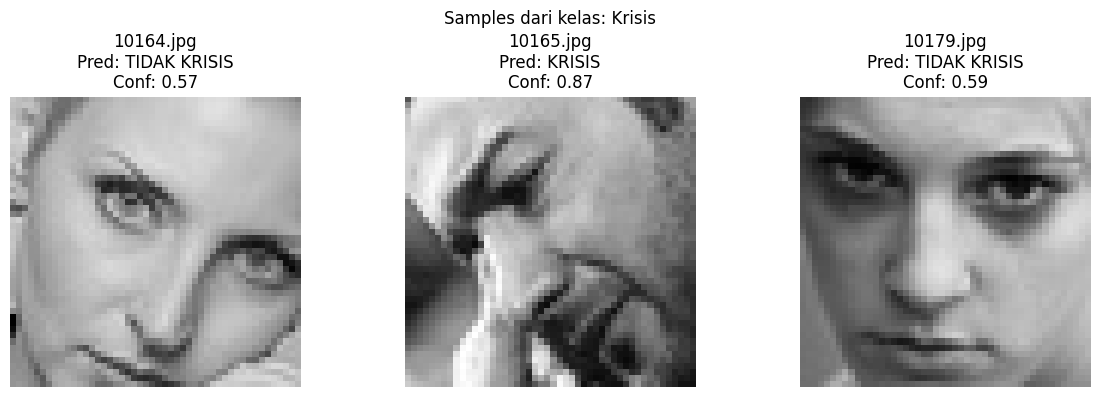


=== 3 Sample dari kelas: Tidak Krisis ===
File: 100.jpg | Prediksi: TIDAK KRISIS | Confidence: 0.6669
File: 1000.jpg | Prediksi: TIDAK KRISIS | Confidence: 0.6069
File: 10018.jpg | Prediksi: KRISIS | Confidence: 0.6448


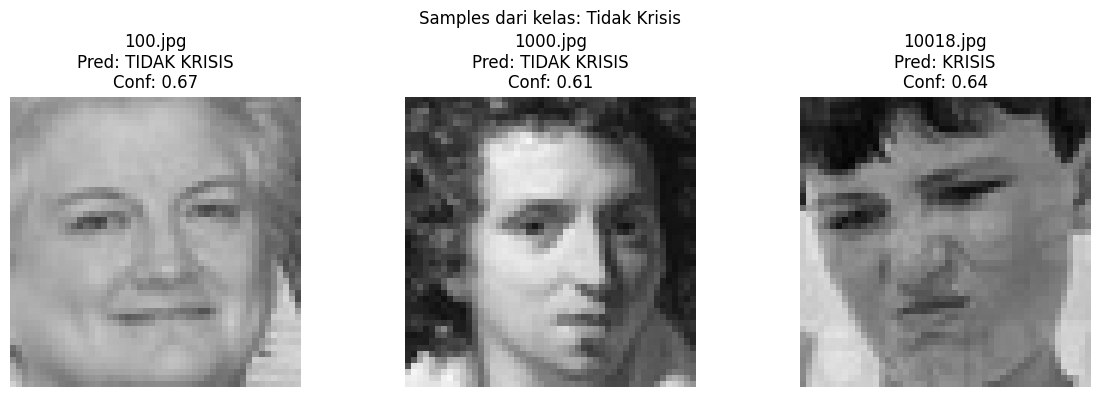

In [1]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

import torch_directml
# device = torch_directml.device()
# ======================
# 1. Definisi Model
# ======================
def get_model(num_classes, variant="large"):
    if variant == "large":
        model = models.mobilenet_v3_large(weights="IMAGENET1K_V1")
        in_feats = model.classifier[0].in_features
    else:
        model = models.mobilenet_v3_small(weights="IMAGENET1K_V1")
        in_feats = model.classifier[0].in_features

    model.classifier = nn.Sequential(
        nn.Linear(in_feats, 128),
        nn.Hardswish(),
        nn.Dropout(p=0.3),
        nn.Linear(128, num_classes)
    )
    return model

# ======================
# 2. Load Model
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=2, variant="large").to(device)

state_dict = torch.load("models/face-expression.pt", map_location=device)
model.load_state_dict(state_dict)
model.eval()
print("[INFO] Model loaded and ready for inference.")

# ======================
# 3. Preprocessing (sesuai training)
# ======================
class To3Channels:
    def __call__(self, x):
        return x.repeat(3, 1, 1) if x.shape[0] == 1 else x

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    To3Channels(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

labels = ["KRISIS", "TIDAK KRISIS"]

def predict_image(model, img_path, device):
    img = Image.open(img_path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_t)
        probs = torch.softmax(outputs, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        conf = probs[0, pred].item()

    return labels[pred], conf, img

# ======================
# 4. Prediksi & Visualisasi
# ======================
data_dir = "data/1. DATA EKSPRESI WAJAH KRISI BUNUH DIRI"
class_dirs = {
    "Krisis": os.path.join(data_dir, "1. KRISIS"),
    "Tidak Krisis": os.path.join(data_dir, "2. TIDAK KRISIS")
}

for class_name, folder in class_dirs.items():
    print(f"\n=== 3 Sample dari kelas: {class_name} ===")
    img_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
    sample_files = img_files[:3]

    plt.figure(figsize=(12, 4))
    for i, img_path in enumerate(sample_files):
        pred, conf, img = predict_image(model, img_path, device)
        print(f"File: {os.path.basename(img_path)} | Prediksi: {pred} | Confidence: {conf:.4f}")

        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{os.path.basename(img_path)}\nPred: {pred}\nConf: {conf:.2f}")

    plt.suptitle(f"Samples dari kelas: {class_name}")
    plt.tight_layout()
    plt.show()
